In [2]:
# run the header that sets up the environment

if "already_run" not in globals():
    globals()["already_run"] = True
    
    %run header.ipynb
    load_packages()
    change_wordir()
    colors, colours = colourblind_palette()

model = "cyclic_2021"
#model = "latest_dev"

#m = load_model(model)
m = load_model(model)


succesfully loaded cyclic_2021 :D


In [3]:
y0 = {
    "PQ": 11.027139850905353,       "PC": 1.8895071932002812,           "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,       "NADPH": 0.48821037006737366,       "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,      "Psbs": 0.9607146039898598,         "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,      "BPGA": 0.0005355311557548053,      "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,    "FBP": 0.006126990841013743,        "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,      "G1P": 0.041575582577936025,        "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,     "E4P": 0.00732079113061801,         "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,     "RUBP": 0.13153657267999222,        "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,    "ASC": 9.999994138785292,           "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,   "GSH": 9.999999991725186,           "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,                   "E_inactive": 4.7368421052631575,
    "P700FA": 1.4731,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.0131,
    "P700FA-": 0.0177,
}

In [17]:
def DIRK(s: Simulator, pre_relax_time: float, pfd_illum: float, 
          relax_time: float, relax_pfd: float, post_relax_time: float):
     """
     illumination -> dark (relaxation) -> illumination
     """     
     # Compute cumulative time points for each simulation phase
     time_points = it.accumulate([pre_relax_time, relax_time, post_relax_time]) #1) i.; 2) i. + ii.; 3) i. + ii. + iii.

     # Corresponding PFD levels for each phase
     pfd_levels = [pfd_illum, relax_pfd, pfd_illum]

     # Run the simulation for each phase
     for time, pfd in tqdm(zip(time_points, pfd_levels)): # zip: eg. "[(1, 800), (3, 0), (6, 800)]"
          s.update_parameter("pfd", pfd)
          #print(f"Time: {time}, PFD: {pfd}")
          s.simulate(time) 


In [18]:
s1 = Simulator(m)
s1.initialise(y0)
s1.clear_results()
DIRK(s1,pre_relax_time=1200, pfd_illum=300, relax_time=0.1, relax_pfd=10, post_relax_time=0.1) 

3it [00:03,  1.08s/it]


In [13]:
c = s1.get_full_results_df()
v = s1.get_fluxes_df()

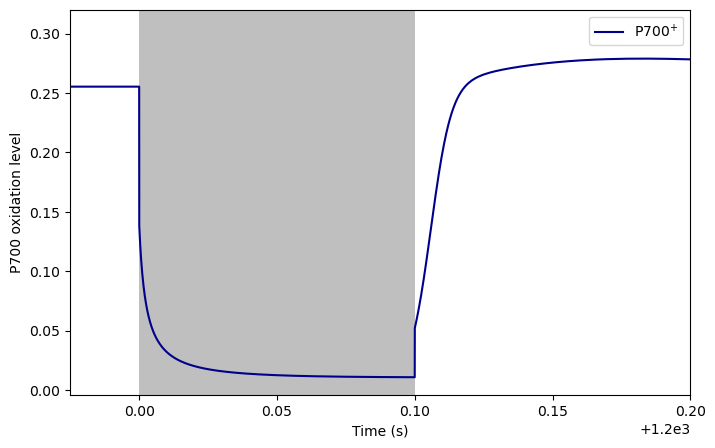

In [14]:
"""
Prior to the measurements, attached leaves of Col-0(black curves) and cfq (red curves) 
were illuminated for at least 20 min with  300 µmol photons·m−2·s−1at and low(50 ppm, thick curves) CO2. 
Kinetics of absorbance changes were measuredusing the IDEASpec device as described in the text. 
As shown in the coloredbands at the top of the graph, the actinic illumination was switched off for 100 ms time intervals 
starting at time zero. Data is plotted as the fraction of P700 oxidized determined by the differences 
in absorbance changes at810–940 nm, normalized to the maximum absorbance changes observedunder 
far red illumination followed by a saturating ﬂash

https://www.researchgate.net/publication/316674887_Chloroplast_ATP_Synthase_Modulation_of_the_Thylakoid_Proton_Motive_Force_Implications_for_Photosystem_I_and_Photosystem_II_Photoprotection
"""
fig,ax=plt.subplots(figsize=(8,5))

ax.plot(c["A2"], label = "P700$^{+}$", color="darkblue")


ax.set(xlim=(1199.975,1200.2),
       xlabel=("Time (s)"),
       ylabel=("P700 oxidation level"))
       
ax.axvspan(1200, 1200.1, color='grey', alpha=0.5, lw=0)
ax.legend()

plt.show()

In [60]:
def PIRK(s: Simulator, ss_pfd: float, dark_pfd:float, pulse_pfd: float,
        pulse_time: float, relax_time: float, time_delay= bool):
    """
    steady state (light) -> dark -> light pulses (fast)
    """

    s.update_parameter("pfd", ss_pfd)
    s.simulate(100)
    s.update_parameter("pfd", dark_pfd)
    s.simulate(160)

    # Define pulsed sequence (alternating pulse/dark PFDs)
    pfds = list([pulse_pfd, dark_pfd]*4)  
    
    # define the intervals
    if time_delay:
        time_points = list(it.accumulate(it.chain.from_iterable(
            (pulse_time, relax_time * factor) for factor in [1, 2, 4, 0.5]
        )))
    else:
        time_points = list(it.accumulate([pulse_time, relax_time]*4)) 
    
    # Adjust all time points by adding the initial dark period (160s)
    time_points = [t + 160 for t in time_points]

    for t, pfd in tqdm(zip(time_points, pfds)):
        print(f"Time: {t}, PFD: {pfd}")
        s.update_parameter("pfd", pfd)
        s.simulate(t)
        

In [61]:
##to be similar to behavior time_relax=0.05, time_pulse = 0.005, pfd_dark=100, pfd_pulse=450, normal_light=400

s1 = Simulator(m)
s1.initialise(y0)
s1.clear_results()
PIRK(s1, ss_pfd=90, dark_pfd=10, pulse_pfd=1180,
     pulse_time=0.003, relax_time=0.06, time_delay=True
     )

0it [00:00, ?it/s]

Time: 160.003, PFD: 1180


1it [00:00,  3.67it/s]

Time: 160.063, PFD: 10


3it [00:01,  2.80it/s]

Time: 160.066, PFD: 1180
Time: 160.186, PFD: 10


4it [00:01,  1.82it/s]

Time: 160.189, PFD: 1180


5it [00:02,  2.31it/s]

Time: 160.429, PFD: 10


6it [00:03,  1.76it/s]

Time: 160.432, PFD: 1180


7it [00:03,  2.14it/s]

Time: 160.462, PFD: 10


8it [00:03,  2.07it/s]


In [62]:
c = s1.get_full_results_df()
v = s1.get_fluxes_df()

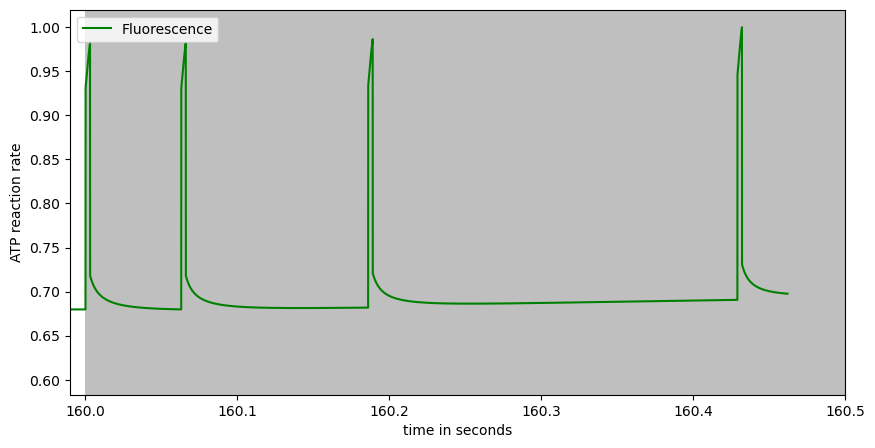

In [63]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(c["Fluo"]/max(c["Fluo"]), label="Fluorescence", color="green")
ax.set(ylabel=("Fluorescence"))
ax.set(xlim=(159.99,160.5),
       #ylim=(0.16,0.5),
       xlabel=("time in seconds"),
       ylabel=("ATP reaction rate"))
ax.axvspan(160, 200, color='grey', alpha=0.5, lw=0)
ax.legend()
plt.show()

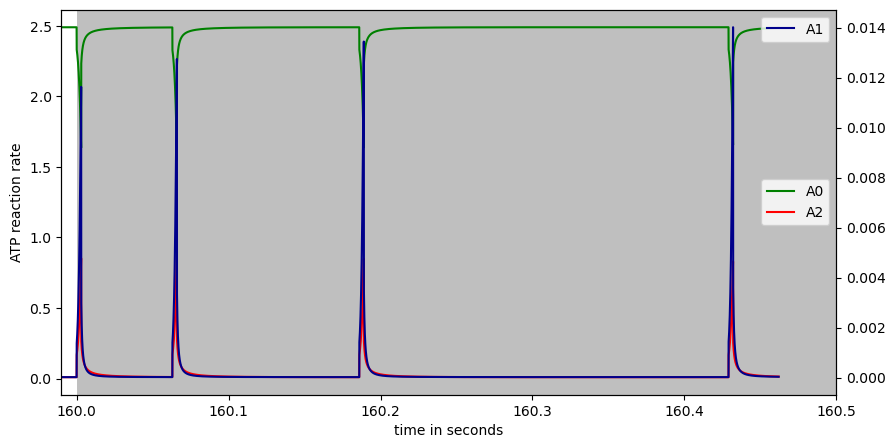

In [64]:
fig,ax=plt.subplots(figsize=(10,5))
ax2= ax.twinx()
ax.plot(c["A0"], label="A0", color="green")
ax2.plot(c["A1"], label="A1", color="darkblue")
ax.plot(c["A2"], label="A2", color ="red")
#ax.plot(v["vATPsynthase"], color="red")
ax.set(ylabel=("Fluorescence"))
ax.set(xlim=(159.99,160.5),
       #ylim=(0.16,0.5),
       xlabel=("time in seconds"),
       ylabel=("ATP reaction rate"))
ax.axvspan(160, 200, color='grey', alpha=0.5, lw=0)
ax.legend()
ax2.legend()
plt.show()

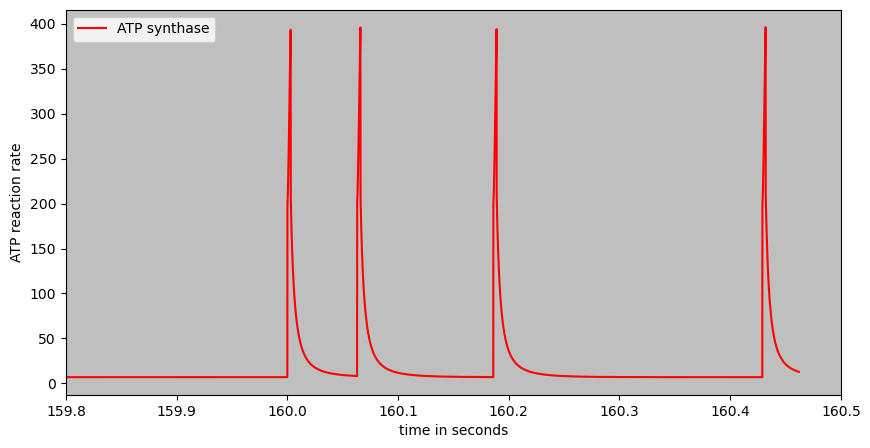

In [12]:
fig,ax=plt.subplots(figsize=(10,5))
#ax.plot(c["Fluo"])
ax.plot(v["vATPsynthase"], color="red", label="ATP synthase")

ax.set(xlim=(159.8,160.5),
       #ylim=(0.16,0.5),
       xlabel=("time in seconds"),
       ylabel=("ATP reaction rate"))
#ax.set_xticklabels(["1200","1300","1400","1500","1600","1700","1800"])
ax.axvspan(100, 660, color='grey', alpha=0.5, lw=0)
ax.legend()
plt.show()

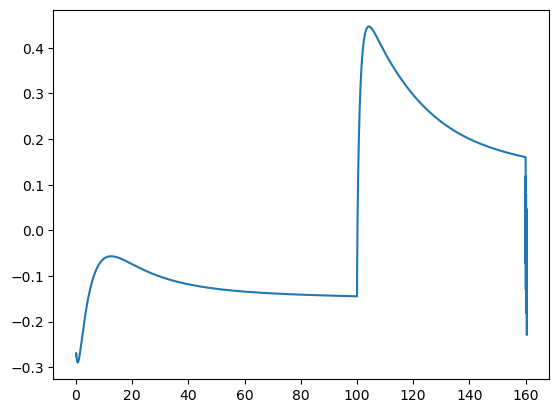

In [13]:
plt.plot(-np.log(s1.get_full_results_df()["Keq_ATPsynthase"])/m.get_parameter("RT"))


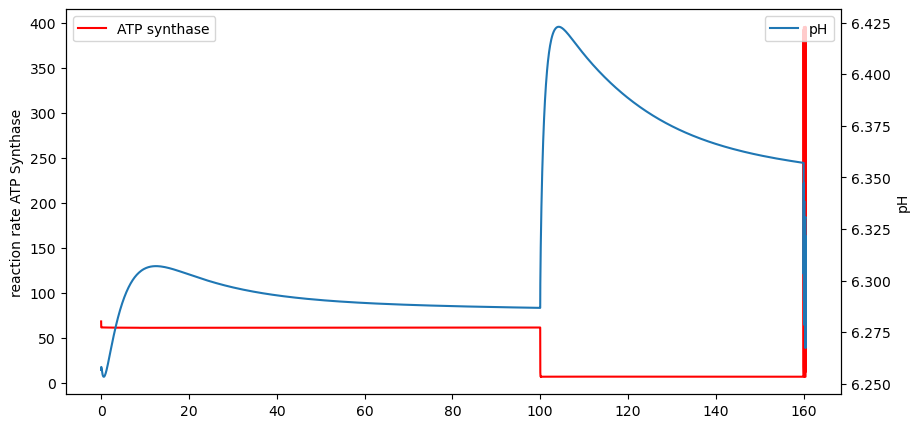

In [14]:
fig,ax=plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
ax2.plot(c["pH"], label="pH")
ax.plot(v["vATPsynthase"], color="red",label="ATP synthase")
ax.set(ylabel=("reaction rate ATP Synthase"))
#ax.set(xlim=(159,160.5),
       #ylim=(0.16,0.5),
       #xlabel=("time in seconds"),
       #ylabel=("ATP reaction rate"))
ax2.set(ylabel=("pH"))
#ax.set_xticklabels(["1200","1300","1400","1500","1600","1700","1800"])
#ax.axvspan(150,240, color='grey', alpha=0.5, lw=0)
ax.legend()
ax2.legend()
plt.show()

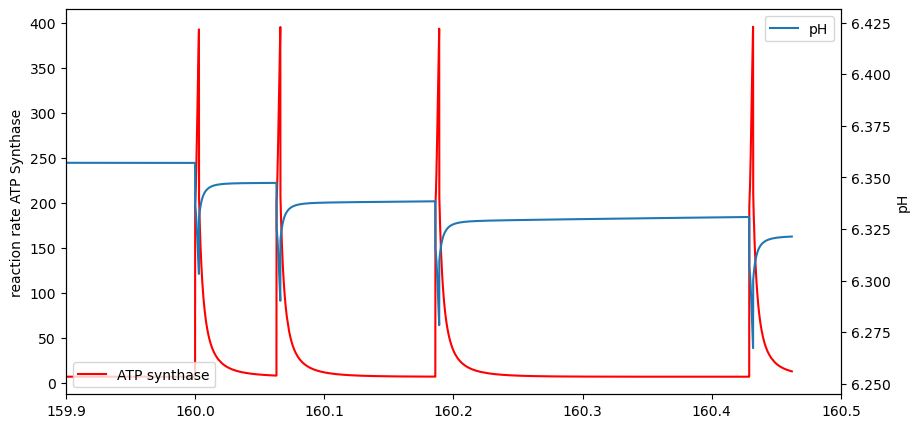

In [15]:
fig,ax=plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
ax2.plot(c["pH"], label="pH")
ax.plot(v["vATPsynthase"], color="red",label="ATP synthase")
ax.set(ylabel=("reaction rate ATP Synthase"))
ax.set(xlim=(159.9,160.5))
ax2.set(ylabel=("pH"))
#ax.set_xticklabels(["1200","1300","1400","1500","1600","1700","1800"])
#ax.axvspan(150,240, color='grey', alpha=0.5, lw=0)
ax.legend()
ax2.legend()
plt.show()

In [16]:
c = s1.get_full_results_df()
f = s1.get_fluxes_df()
B0 = s1.get_variable("B0")
B2 = s1.get_variable("B2")
ADP = 1-c["ATP_norm"]

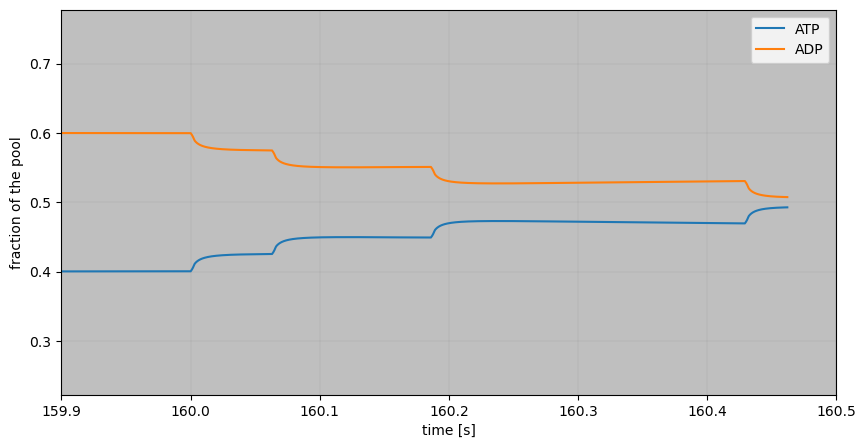

In [17]:
###ATP and ADP
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(c["ATP_norm"], label= "ATP")
ax.set(xlim=(159.9,160.5))

ax.plot(ADP, label = "ADP")
plt.ylabel("fraction of the pool")
plt.xlabel("time [s]")
plt.axvspan(150, 240, color='grey', alpha=0.5, lw=0)
plt.grid(color='grey', linestyle='-', linewidth=0.1)
plt.legend(loc="best")
plt.show()

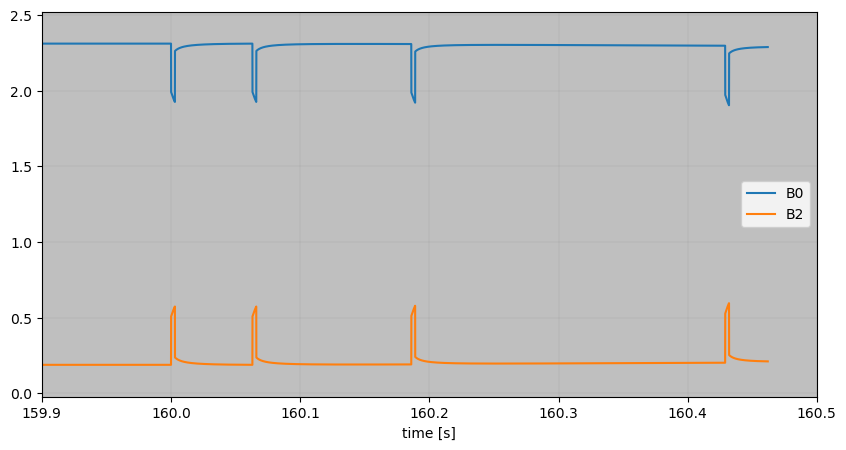

In [18]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(f.index, B0, label="B0")
ax.plot(f.index, B2, label="B2")
ax.set(xlim=(159.9,160.5))
plt.xlabel("time [s]")
plt.axvspan(100, 650, color='grey', alpha=0.5, lw=0)
plt.grid(color='grey', linestyle='-', linewidth=0.1)
plt.legend(loc="best")